In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [70]:
pip install imblearn

     -------------------------------------- 235.6/235.6 kB 4.8 MB/s eta 0:00:00
     ------------------------------------- 302.2/302.2 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import load_breast_cancer
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
import seaborn as sns
%matplotlib inline

### 결측치 처리

- 결측치 확인

In [2]:
wine = pd.read_csv('./data/2-1_wine.csv', index_col=0)
print('**원본 데이터:\n', wine.isna().sum())

**원본 데이터:
 class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64


In [3]:
# 결측치가 없으므로 두 개의 컬럼(Alcohol, Ash)에 임의로 결측치를 입력함.
# randint(최소, 최대, 개수)
wine_m = wine.copy()

for col in ['Alcohol', 'Ash'] : 
    for i in range(20) : 
        random_idx = np.random.randint(0, len(wine), 1)
        wine_m.loc[random_idx, col] = np.nan

print('\n**결측치 생성 데이터:\n', wine_m.isna().sum())


**결측치 생성 데이터:
 class                            0
Alcohol                         20
Malicacid                        0
Ash                             19
Alcalinity_of_ash                0
Magnesium                        0
Total_phenols                    0
Flavanoids                       0
Nonflavanoid_phenols             0
Proanthocyanins                  0
Color_intensity                  0
Hue                              0
0D280_0D315_of_diluted_wines     0
Proline                          0
dtype: int64


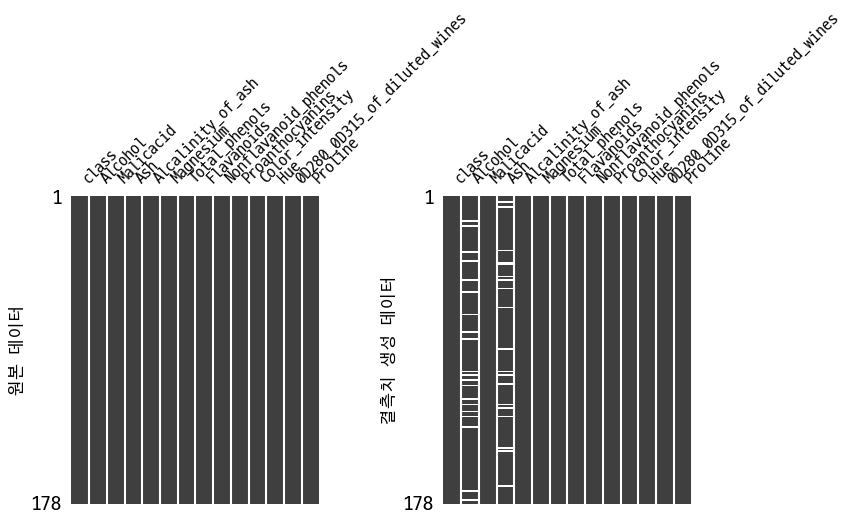

In [4]:
# plotting 환경 설정
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

# 결측치 시각화(missingno)
msno.matrix(df=wine, figsize=(5,5), fontsize=12, ax=ax[0], sparkline=False)
ax[0].set_ylabel('원본 데이터')

msno.matrix(df=wine_m, figsize=(5,5), fontsize=12, ax=ax[1], sparkline=False)
ax[1].set_ylabel('결측치 생성 데이터')

plt.show()

- zero imputation과 constant imputaion

In [5]:
# 대치 전: wine_m
print(wine_m[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37   NaN
4    13.24  2.87
5    14.20  2.45
6    14.39   NaN
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [6]:
# 0으로 대치 후: wine_imp
wine_imp = wine_m.fillna(0)
print(wine_imp[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  0.00
4    13.24  2.87
5    14.20  2.45
6    14.39  0.00
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [7]:
# 1000으로 대치 후: wine_imp
wine_imp = wine_m.fillna(1000)
print(wine_imp[['Alcohol','Ash']].head(10))

   Alcohol      Ash
0    14.23     2.43
1    13.20     2.14
2    13.16     2.67
3    14.37  1000.00
4    13.24     2.87
5    14.20     2.45
6    14.39  1000.00
7    14.06     2.61
8    14.83     2.17
9    13.86     2.27


- 대표값으로 채우는 방법

In [8]:
# 대표값으로 채우기 전: wine_m
print(wine_m[['Alcohol','Ash']].head(10))

   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37   NaN
4    13.24  2.87
5    14.20  2.45
6    14.39   NaN
7    14.06  2.61
8    14.83  2.17
9    13.86  2.27


In [9]:
# 대표값(mean)으로 채운 후: wine_imp1
# 전략 : 평균, 중위수, 최빈값
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = pd.DataFrame(wine_imp1, columns=wine_m.columns)

In [10]:
Al_mean = wine_m['Alcohol'].mean()
As_mean = wine_m['Ash'].mean()

In [11]:
print(f'Alcohol mean: {Al_mean:.5f}, Ash mean: {As_mean:.5f}')
print(wine_imp1[['Alcohol','Ash']].head(10))

Alcohol mean: 13.03658, Ash mean: 2.36723
   Alcohol       Ash
0    14.23  2.430000
1    13.20  2.140000
2    13.16  2.670000
3    14.37  2.367233
4    13.24  2.870000
5    14.20  2.450000
6    14.39  2.367233
7    14.06  2.610000
8    14.83  2.170000
9    13.86  2.270000


- 단순확률대치법
  1) Hot-deck : 연구와 비슷한 성향의 데이터
  2) Cold-deck : 외부 출처/이전의 비슷한 연구의 데이터

In [12]:
# Hot-deck 대치 후: wine_imp2
# Hot-deck 함수 정의
def HotDeck(data, reference) : 
    imp = data.copy()
    check = imp.isna().sum()
    for col, val in zip(check.index, check.values) : 
        if val == 0 : 
            continue
        else : 
            imp[col] = imp[col].apply(lambda x: 
                                      float(reference[col].sample(1).values) 
                                      if str(x) == 'nan' else x)
    return imp

In [13]:
# wine 데이터가 wine_m 데이터와 비슷한 성향을 가졌다고 가정하고 랜덤 샘플링함.
wine_imp2 = HotDeck(wine_m, wine)
wine_imp2.isna().sum()

class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

- 다른 변수들로부터 모델링하여 결측값을 예측하는 방법

In [14]:
# KNNImputer 대치 후: wine_imp3
imputer = KNNImputer(n_neighbors=3)
wine_imp3 = imputer.fit_transform(wine_m)
wine_imp3 = pd.DataFrame(wine_imp3, columns=wine_m.columns)
wine_imp3.isna().sum()

class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

- 보간법

In [15]:
# 선형보간법 후: wine_imp4
wine_imp4 = wine_m.interpolate(method='linear')
wine_imp4.isna().sum()

class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

- 실제값과 대치값의 비교

In [16]:
# 결측치가 있는 행의 인덱스를 찾는 함수 정의
def find_missing_idx(data, column) : 
    return np.argwhere(np.array(data[[column]].isna().sum(axis=1))>0).ravel()

In [17]:
# Alcohol feature 기준으로 대치값 비교
feature = 'Alcohol'
missing_idx = find_missing_idx(wine_m, feature)

report = pd.DataFrame({'실제값':wine[feature], 'mean대치':wine_imp1[feature],
                       'HotDeck':wine_imp2[feature], 'KNN대치':wine_imp3[feature],
                       '선형보간':wine_imp4[feature]})

missing_report = report.iloc[missing_idx,:]

score_report = pd.DataFrame(index=['MAE','MSE'])

for col in missing_report.columns : 
    mae = mean_absolute_error(missing_report['실제값'],missing_report[col])
    mse = mean_squared_error(missing_report['실제값'],missing_report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse
print(score_report)

     실제값    mean대치   HotDeck     KNN대치      선형보간
MAE  0.0  0.811816  1.046500  0.614333  0.374750
MSE  0.0  0.838205  1.614765  0.674980  0.230909


In [18]:
# Ash feature 기준으로 대치값 비교
feature = 'Ash'
missing_idx = find_missing_idx(wine_m, feature)

report = pd.DataFrame({'실제값':wine[feature], 'mean대치':wine_imp1[feature],
                       'HotDeck':wine_imp2[feature], 'KNN대치':wine_imp3[feature],
                       '선형보간':wine_imp4[feature]})

missing_report = report.iloc[missing_idx,:]

score_report = pd.DataFrame(index=['MAE','MSE'])

for col in missing_report.columns : 
    mae = mean_absolute_error(missing_report['실제값'], missing_report[col])
    mse = mean_squared_error(missing_report['실제값'], missing_report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse
print(score_report)

     실제값    mean대치   HotDeck     KNN대치      선형보간
MAE  0.0  0.206753  0.313684  0.230175  0.216579
MSE  0.0  0.066597  0.159042  0.075621  0.069978


### 이상치 처리

- 절단

In [19]:
# 이상치 절단 함수 정의
def del_outlier(df, columns, method='iqr') : 
    columns = np.array(columns).flatten().tolist()
    check_df = df.loc[:, columns]
    if method == 'iqr' : 
        IQR = check_df.quantile(0.75) - check_df.quantile(0.25)
        top = check_df.quantile(0.75) + IQR * 1.5
        down = check_df.quantile(0.25) - IQR * 1.5
    elif method == 'esd' : 
        std = check_df.std()
        mean = check_df.mean()
        top = mean + std * 3
        down = mean - std * 3
    prep_dfs = []
    for col in columns : 
        out_id = check_df[(check_df[col] >= top[col])|
                          (check_df[col] <= down[col])][col].index
        check_df.drop(out_id, axis=0, inplace=True) # 이상치 제거하기
        prep_dfs.append(check_df[[col]])
    if len(prep_dfs) == 1 :
        prep_dfs = prep_dfs[0]
    return prep_dfs


In [20]:
# 이상치 처리 전후 시각화 함수 정의
def before_after_boxplot(df1,df2,figsize=(10,5),fontsize=13) : 
    fig, axes = plt.subplots(1,2)
    plt.rcParams['figure.figsize'] = figsize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.unicode_minus'] = False

    for data, ax, title in zip([df1,df2], axes, ['Before','After']) : 
        data.boxplot(ax=ax)
        ax.set_title(f'{title} ({len(data)})')
        margin = df1.std().values[0]/2
        ax.set_ylim(df1.min().values[0]-margin, df1.max().values[0]+margin)
    plt.show()

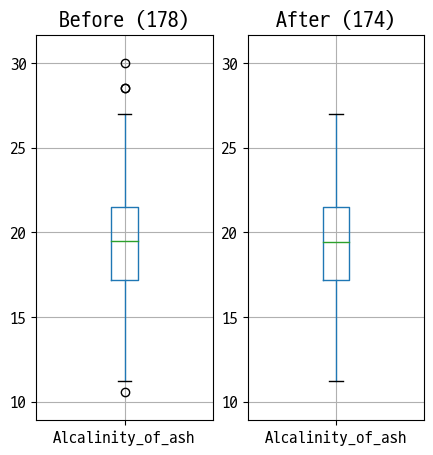

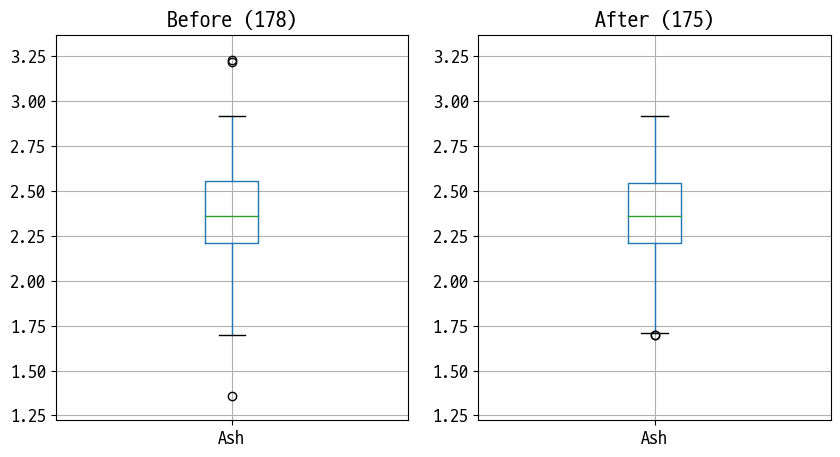

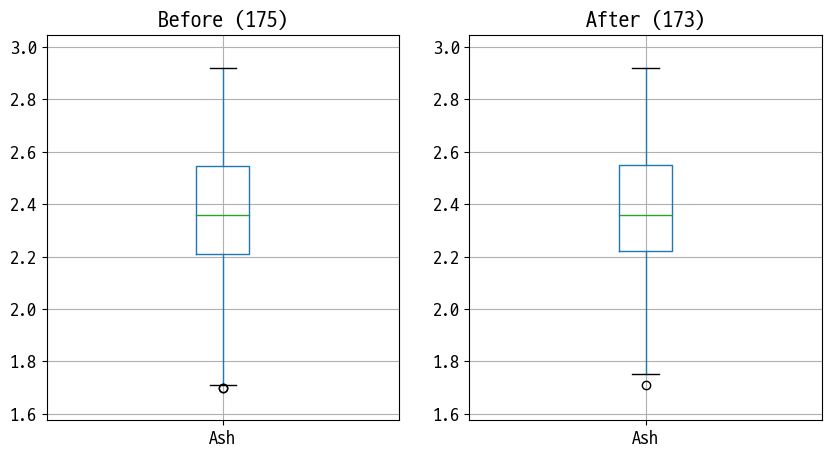

In [21]:
# prep_Alcal = prep_Ash = del_outlier(wine, ['Alcalinity_of_ash', 'Ash'], method='iqr')
prep_Alcal = del_outlier(wine, ['Alcalinity_of_ash'], method='iqr')
prep_Ash = del_outlier(wine, ['Ash'], method='iqr')

# Alcalinity_of_ash의 이상치 제거 전후
before = wine[['Alcalinity_of_ash']]
before_after_boxplot(before, prep_Alcal)

# Ash의 이상치 제거 전후
before = wine[['Ash']]
before_after_boxplot(before, prep_Ash)

# Ash의 두번째 이상치 제거 전후
before = prep_Ash
prep_Ash2 = del_outlier(prep_Ash, 'Ash')
before_after_boxplot(before, prep_Ash2)

- 조정 : 이상치를 경계값으로 보정

In [22]:
# 이상치 조정 함수 정의
def win_outlier(df, columns, method='iqr') : 
    columns = np.array(columns).flatten().tolist()
    check_df = df.loc[:,columns]
    if method == 'iqr' : 
        IQR = check_df.quantile(0.75)-check_df.quantile(0.25)
        top = check_df.quantile(0.75)+IQR*1.5
        down = check_df.quantile(0.25)-IQR*1.5
    elif method == 'esd' : 
        std = check_df.std()
        mean = check_df.mean()
        top = mean + std*3
        down = mean - std*3
    for col in columns : 
        check_df[col] = check_df[col].clip(down[col], top[col])
    return check_df

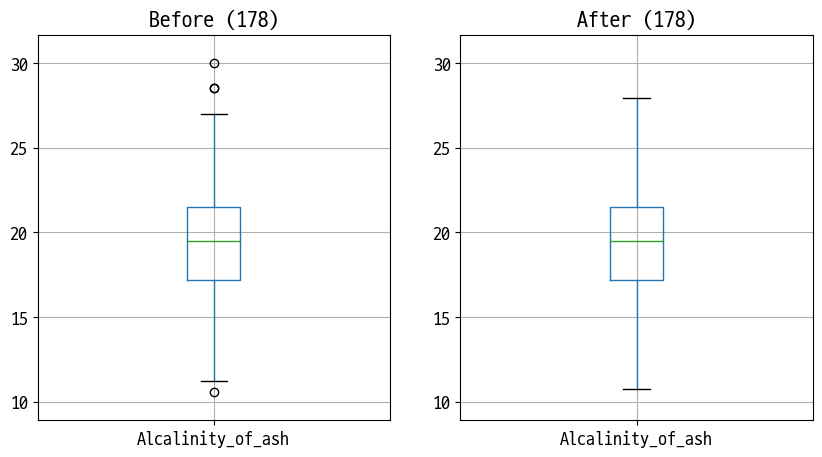

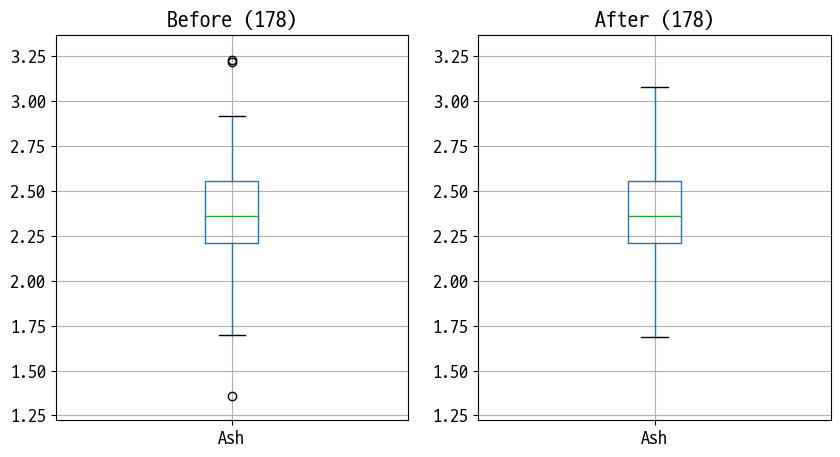

In [23]:
preps = win_outlier(wine, ['Alcalinity_of_ash','Ash'])

# Alcalinity_of_ahs의 이상치 조정 전후
before = wine[['Alcalinity_of_ash']]
before_after_boxplot(before, preps[['Alcalinity_of_ash']])

# Ash의 이상치 조정 전후
before = wine[['Ash']]
before_after_boxplot(before, preps[['Ash']])

- 클리핑(Clipping) : 이상치의 상한과 하한을 특정 숫자로 설장해서 이상치를 상한값과 하한값으로 보정하는 방법

In [24]:
# 이상치 클리핑 함수 정의
def clip_outlier(df, columns, downtop) : 
    columns = np.array(columns).flatten().tolist()
    check_df = df.loc[:,columns]
    for col, dt in zip(columns, downtop) : 
        check_df[col] = check_df[col].clip(dt[0], dt[1])
    return check_df

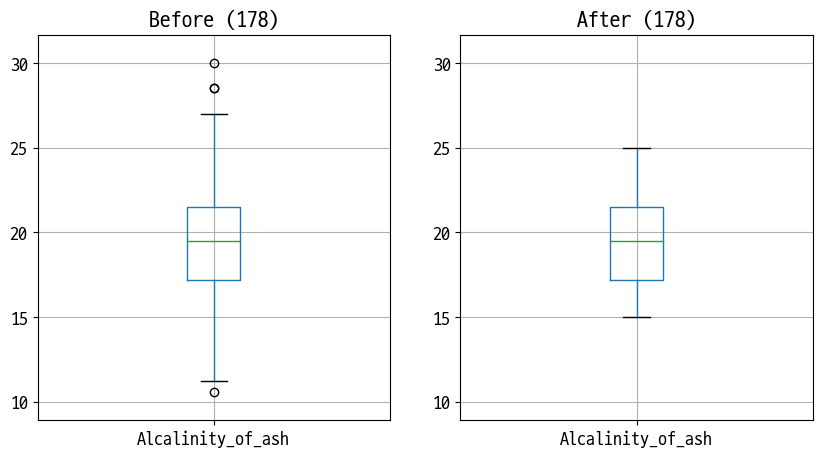

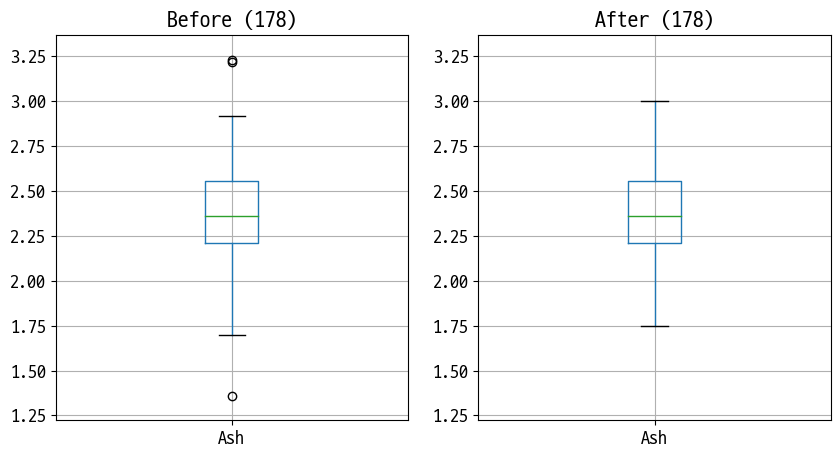

In [25]:
preps = clip_outlier(wine, ['Alcalinity_of_ash','Ash'], [(15,25),(1.75,3)])

# Alcalinity_of_ash의 클리핑 전후
before = wine[['Alcalinity_of_ash']]
before_after_boxplot(before, preps[['Alcalinity_of_ash']])

# Ash의 클리핑 전후
before = wine[['Ash']]
before_after_boxplot(before, preps[['Ash']])

### 클래스 불균형 처리

- 클래스 불균형 데이터 생성하기

In [26]:
data = load_breast_cancer()
df = pd.DataFrame(np.c_[data['data'], data['target']], columns=['x%s' %i for i in range(data['data'].shape[1])]+['y'])

print('original data의 class 분포:', Counter(data['target']))
df1 = df[df['y']==0].sample(50)
df2 = df[df['y']==1].sample(250)
# 전체 특성 중 4개만 사용
imb_df = pd.concat([df1,df2]).reset_index(drop=True).iloc[:,-5:]
print('imbalanced data의 calss 분포:\n', Counter(imb_df['y']))

features = imb_df.drop('y', axis=1)
target = imb_df['y']

print(imb_df.head(3))

original data의 class 분포: Counter({1: 357, 0: 212})
imbalanced data의 calss 분포:
 Counter({1.0: 250, 0.0: 50})
      x26     x27     x28      x29    y
0  0.3759  0.1510  0.3074  0.07863  0.0
1  0.2416  0.1860  0.2750  0.08902  0.0
2  0.5588  0.1847  0.3530  0.08482  0.0


- 랜덤오버샘플링

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


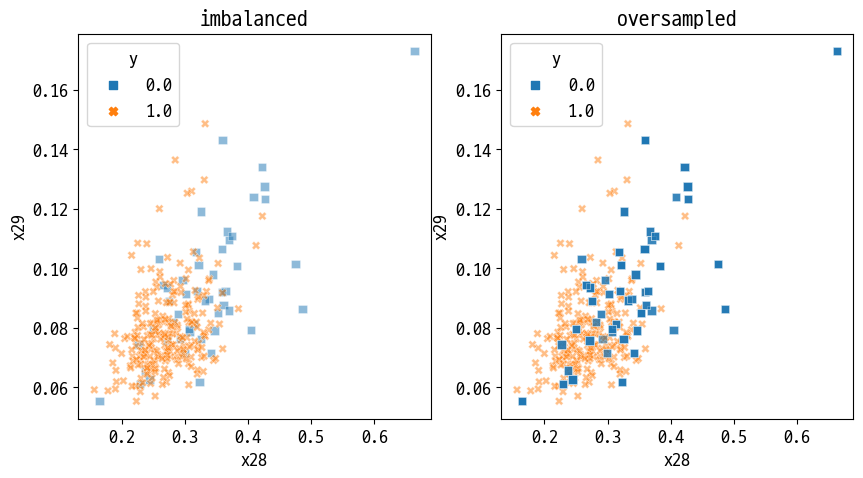

In [27]:
os = RandomOverSampler()
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

over_df1 = pd.DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

fig, ax = plt.subplots(1,2)
ax[0].set_title('imbalanced')
ax[1].set_title('oversampled')
sns.scatterplot(x='x28', y='x29', hue='y', data=imb_df, ax=ax[0], alpha=0.5, style='y', markers=['s','X'])
sns.scatterplot(x='x28', y='x29', hue='y', data=over_df1, ax=ax[1], alpha=0.5, style='y', markers=['s','X'])

plt.show()

- SMOTE(Synthetic minority oversampling technique)
  - 임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터를 생성하는 방법

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


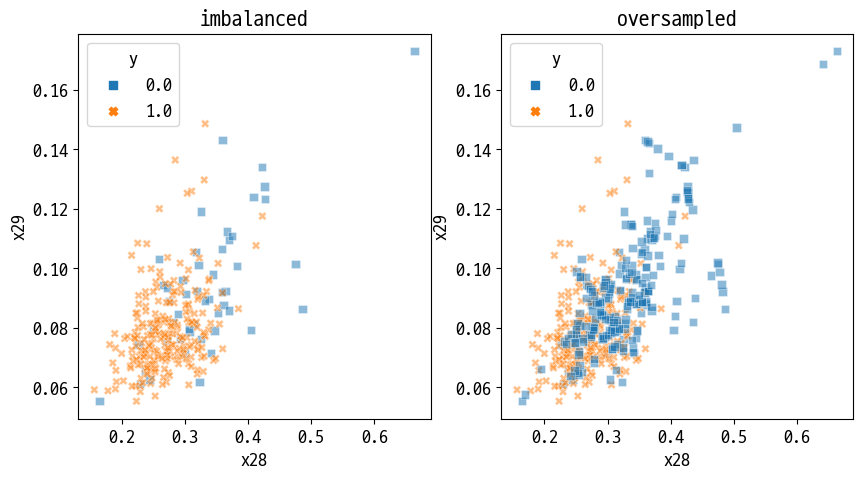

In [28]:
os = SMOTE(random_state=42, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

over_df2 = pd.DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

fig, ax = plt.subplots(1,2)
ax[0].set_title('imbalanced')
ax[1].set_title('oversampled')
sns.scatterplot(x='x28', y='x29', hue='y', data=imb_df, ax=ax[0], alpha=0.5, style='y', markers=['s','X'])
sns.scatterplot(x='x28', y='x29', hue='y', data=over_df2, ax=ax[1], alpha=0.5, style='y', markers=['s','X'])

plt.show()

- Borderline SMOTE 
  - 다수 클래스와 소수 클래스를 구분하는 선을 그을 때 경계선에 있는 소수 클래스에 SMOTE기법 적용하는 방법

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


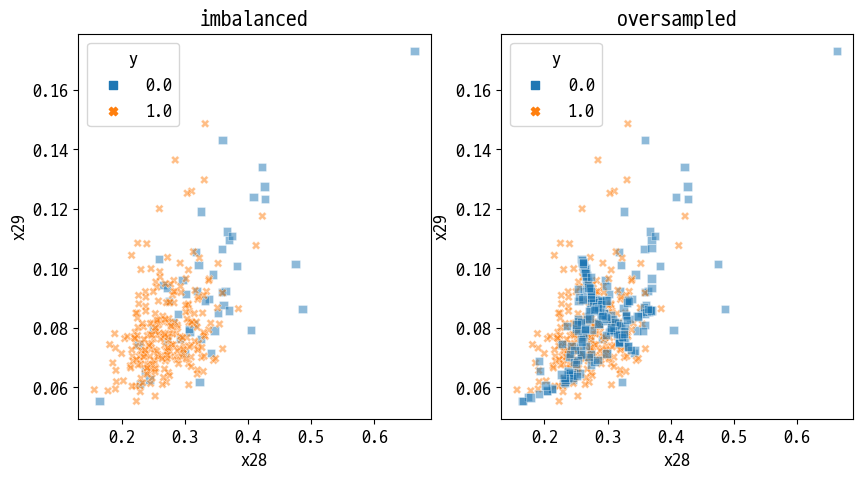

In [29]:
os = BorderlineSMOTE(random_state=0, k_neighbors=5)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

over_df3 = pd.DataFrame(np.c_[bal_features,bal_target], columns=imb_df.columns)

fig, ax = plt.subplots(1,2)
ax[0].set_title('imbalanced')
ax[1].set_title('oversampled')
sns.scatterplot(x='x28', y='x29', hue='y', data=imb_df, ax=ax[0], alpha=0.5, style='y', markers=['s','X'])
sns.scatterplot(x='x28', y='x29', hue='y', data=over_df3, ax=ax[1], alpha=0.5, style='y', markers=['s','X'])

plt.show()

- K-means SMOTE

In [32]:
# os = KMeansSMOTE(random_state=0, k_neighbors=5)
# bal_features, bal_target = os.fit_resample(features, target)


- SVM SMOTE

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 250, 1.0: 250})


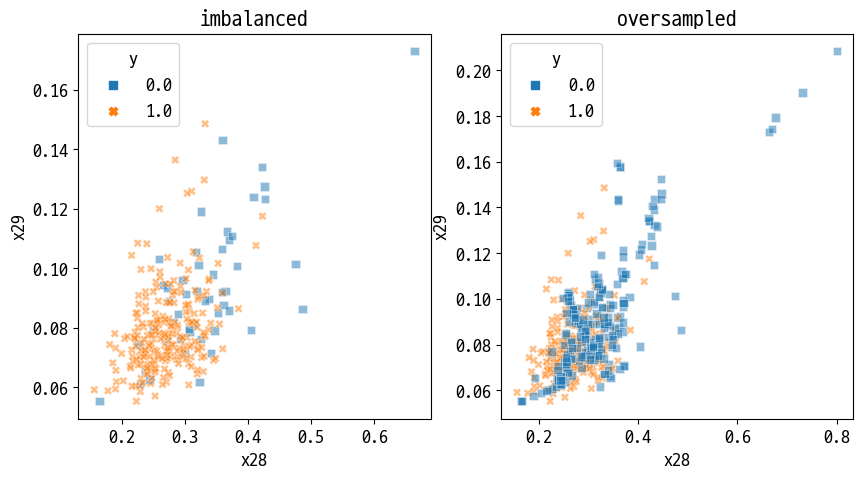

In [33]:
os = SVMSMOTE(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

over_df5 = pd.DataFrame(np.c_[bal_features,bal_target], columns=imb_df.columns)

fig, ax = plt.subplots(1,2)
ax[0].set_title('imbalanced')
ax[1].set_title('oversampled')
sns.scatterplot(x='x28', y='x29', hue='y', data=imb_df, ax=ax[0], alpha=0.5,
                style='y', markers=['s','X'])
sns.scatterplot(x='x28', y='x29', hue='y', data=over_df5, ax=ax[1], alpha=0.5,
                style='y', markers=['s','X'])

plt.show()

- ADASYN(Adaptive synthetic sampling)
  - 생성되는 샘플의 개수는 소수 클래스의 밀도에 반비례함.

imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포: Counter({0.0: 254, 1.0: 250})


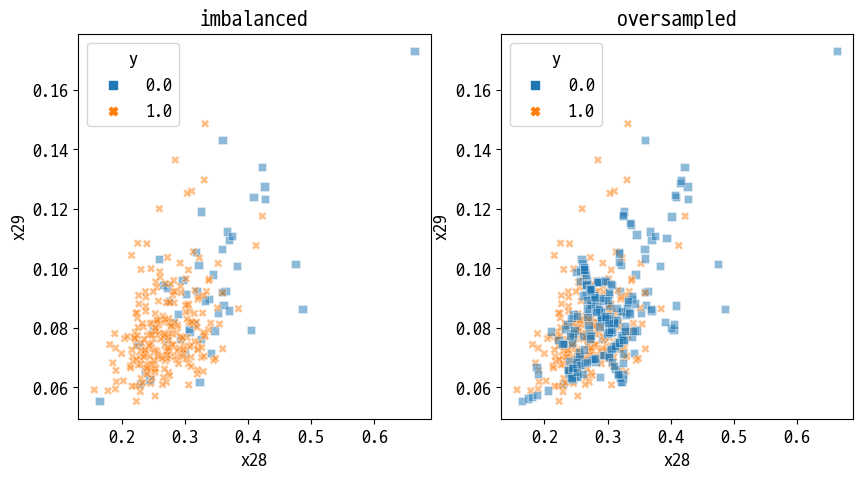

In [34]:
os = ADASYN(random_state=42, n_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포: %s' % Counter(target))
print('oversampled data의 class 분포: %s' % Counter(bal_target))

over_df6 = pd.DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

fig, ax = plt.subplots(1,2)
ax[0].set_title('imbalanced')
ax[1].set_title('oversampled')
sns.scatterplot(x='x28', y='x29', hue='y', data=imb_df, ax=ax[0], alpha=0.5,
                style='y', markers=['s','X'])
sns.scatterplot(x='x28', y='x29', hue='y', data=over_df6, ax=ax[1], alpha=0.5,
                style='y', markers=['s','X'])


plt.show()

- 오버샘플링 데이터로 분류 학습 및 결과 비교

In [40]:
data = [imb_df, over_df1, over_df2, over_df3, over_df5, over_df6]
data_title = ['no oversampling', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 
              'SVMSMOTE', 'ADASYN']
scores = pd.DataFrame(index=['Train acc', 'Test acc', 'Train F1', 'Test F1'], columns=data_title)
for df, title in zip(data, data_title) : 
    X = df.drop('y', axis=1)
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['Train Fl', title] = f1_score(y_train, pred_train)
    scores.loc['Test F1', title] = f1_score(y_test, pred_test)

print(scores)

          no oversampling RandomOverSampler     SMOTE BorderlineSMOTE  \
Train acc        0.835556          0.882667  0.866667        0.882667   
Test acc         0.906667              0.88     0.888            0.92   
Train F1              NaN               NaN       NaN             NaN   
Test F1          0.950355          0.888889  0.887097        0.910714   
Train Fl         0.906329           0.88172  0.870466        0.875706   

           SVMSMOTE    ADASYN  
Train acc     0.912  0.820106  
Test acc      0.912  0.833333  
Train F1        NaN       NaN  
Test F1    0.921986  0.839695  
Train Fl   0.900901  0.808989  


### 변수변환

#### 수치형 변수 변환

In [43]:
diabetes = pd.read_csv('./data/2-4_diabetes.csv')
X = diabetes.filter(['Pregnancies', 'BloodPressure', 'BMI', 'Age']) # 4개 특징만 선정
y = diabetes['Outcome']

- 표준화

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature 별 데이터 분포 확인:
       Pregnancies  BloodPressure           BMI           Age
mean  2.544261e-17  -1.327244e-17  2.295979e-16  1.857600e-16
std   1.000652e+00   1.000652e+00  1.000652e+00  1.000652e+00
max   3.906578e+00   2.734528e+00  4.455807e+00  4.063716e+00
min  -1.141852e+00  -3.572597e+00 -4.060474e+00 -1.041549e+00


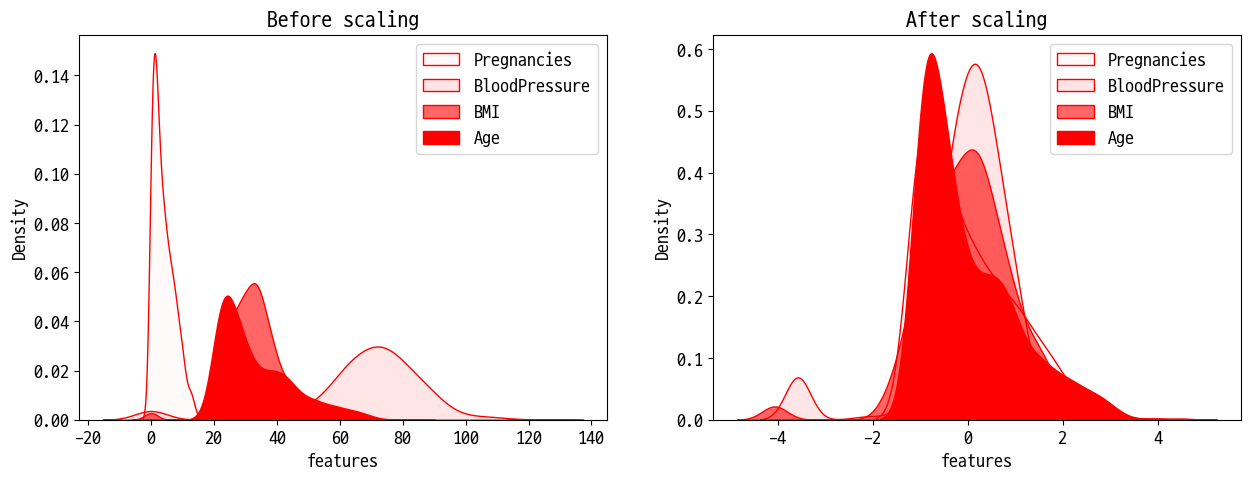

In [58]:
print('[Before] feature 별 데이터 분포 확인:')
print(X.describe().loc[['mean', 'std', 'max', 'min'], :])

# 표준화
ss = StandardScaler()
ss_X = ss.fit_transform(X)
ss_X = pd.DataFrame(ss_X, columns=X.columns)
print('[After] feature 별 데이터 분포 확인:')
print(ss_X.describe().loc[['mean', 'std', 'max', 'min'], :])

# 표준화 전후 데이터 분포 시각화
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02,0.1,0.6,1]) : 
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(ss_X.columns, [0.02,0.1,0.6,1]) : 
    sns.kdeplot(ss_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(ss_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')

plt.show()

- 최소최대 스케일링

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean      0.22618       0.566438  0.476790  0.204015
std       0.19821       0.158654  0.117499  0.196004
max       1.00000       1.000000  1.000000  1.000000
min       0.00000       0.000000  0.000000  0.000000


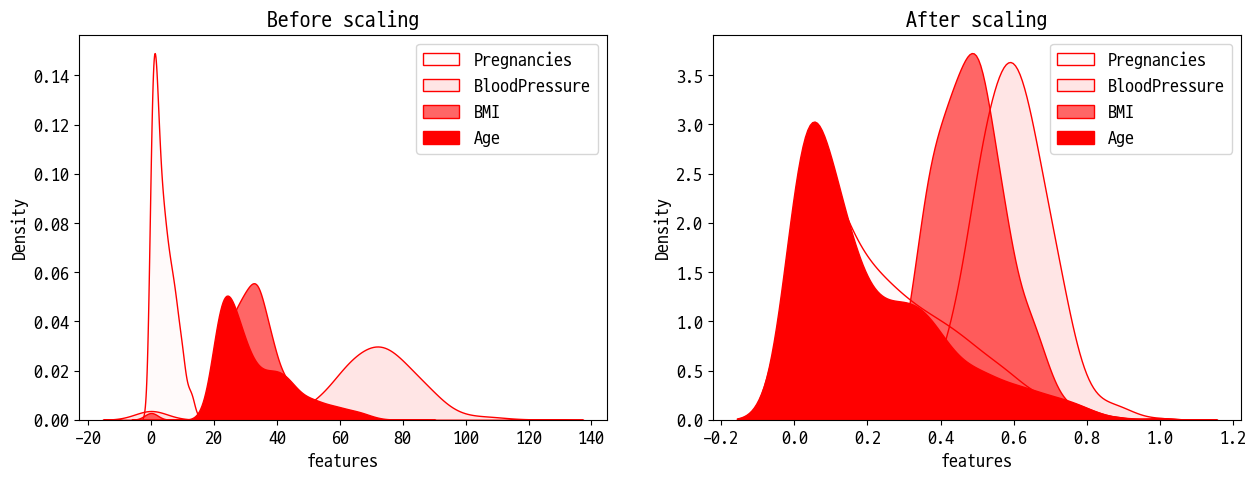

In [65]:
print('[Before] feature 별 데이터 분포 확인:')
print(X.describe().loc[['mean', 'std', 'max', 'min'],:])

# 특징 scaling
mm = MinMaxScaler()
mm_X = mm.fit_transform(X)
mm_X = pd.DataFrame(mm_X, columns=X.columns)
print('[After] feature 별 데이터 분포 확인:')
print(mm_X.describe().loc[['mean', 'std', 'max', 'min'], :])

# scaling 전후 데이터 분포 비교 시각화
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(mm_X, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(mm_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(mm_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')

plt.show()

- Robust scaling : 중앙값, 사분위수를 사용하기 때문에 이상치의 영향을 받지 않음.

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
min      0.000000       0.000000   0.000000  21.000000
max     17.000000     122.000000  67.100000  81.000000
[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean     0.169010      -0.160807 -0.000798  0.249464
std      0.673916       1.075323  0.847759  0.691778
min     -0.600000      -4.000000 -3.440860 -0.470588
max      2.800000       2.777778  3.774194  3.058824


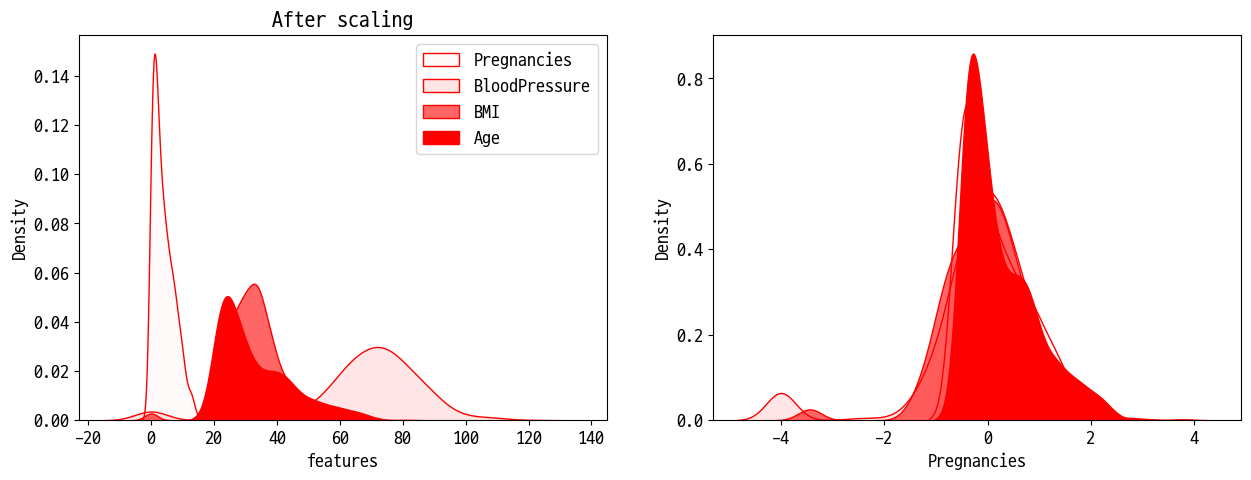

In [73]:
print('[Before] feature 별 데이터 분포 확인:')
print(X.describe().loc[['mean', 'std', 'min', 'max'], :])

# RobustScaler
rs = RobustScaler()
rs_X = rs.fit_transform(X)
rs_X = pd.DataFrame(rs_X, columns=X.columns)
print('[After] feature 별 데이터 분포 확인:')
print(rs_X.describe().loc[['mean', 'std', 'min', 'max'], :])

# scaling 전후 데이터 분포 시각화
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(rs_X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(rs_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[0].legend(rs_X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('After scaling')

plt.show()

- Quantile scaling

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
min      0.000000       0.000000   0.000000  21.000000
max     17.000000     122.000000  67.100000  81.000000
[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean     0.489773       0.499110  0.499972  0.496769
std      0.303331       0.290718  0.289391  0.294365
min      0.000000       0.000000  0.000000  0.000000
max      1.000000       1.000000  1.000000  1.000000


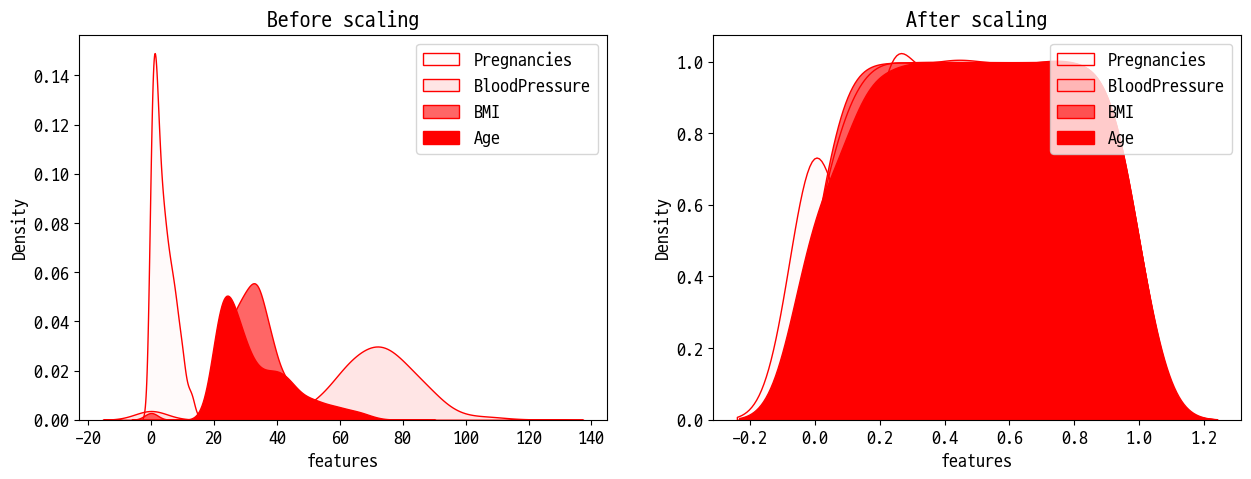

In [94]:
print('[Before] feature 별 데이터 분포 확인:')
print(X.describe().loc[['mean', 'std', 'min', 'max'], :])

# QuantileTransformer로 특징 scaling
qtu = QuantileTransformer(output_distribution='uniform', n_quantiles=len(X))
qtu_X = qtu.fit_transform(X)
qtu_X = pd.DataFrame(qtu_X, columns=X.columns)
print('[After] feature 별 데이터 분포 확인:')
print(qtu_X.describe().loc[['mean', 'std', 'min', 'max'], :])

# scaling 전후 데이터 분포 비교 시각화
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(qtu_X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(qtu_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(qtu_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')

plt.show()

[Before] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
min      0.000000       0.000000   0.000000  21.000000
max     17.000000     122.000000  67.100000  81.000000
[After] feature 별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean    -0.518602      -0.137647 -0.034803 -0.270105
std      2.066619       1.426041  1.150110  1.696606
min     -5.199338      -5.199338 -5.199338 -5.199338
max      5.199338       5.199338  5.199338  5.199338


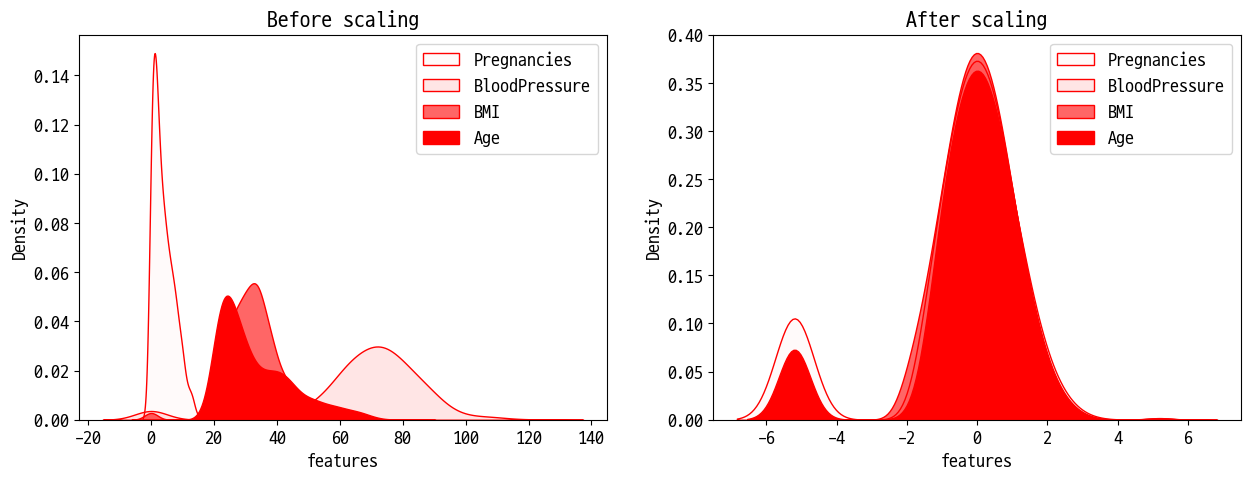

In [95]:
print('[Before] feature 별 데이터 분포 확인:')
print(X.describe().loc[['mean', 'std', 'min', 'max'], :])

# QuantileTransformer로 특징 scaling
qtn = QuantileTransformer(output_distribution='normal', n_quantiles=len(X))
qtn_X = qtn.fit_transform(X)
qtn_X = pd.DataFrame(qtn_X, columns=X.columns)
print('[After] feature 별 데이터 분포 확인:')
print(qtn_X.describe().loc[['mean', 'std', 'min', 'max'], :])

# scaling 전후 데이터 분포 비교 시각화
fig, ax = plt.subplots(1,2, figsize=(15,5))
for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], shade=True, color='r')
ax[0].legend(X.columns)
ax[0].set_xlabel('features')
ax[0].set_title('Before scaling')

for col, a in zip(qtn_X.columns, [0.02, 0.1, 0.6, 1]) : 
    sns.kdeplot(qtn_X[col], alpha=a, legend=True, ax=ax[1], shade=True, color='r')
ax[1].legend(qtn_X.columns)
ax[1].set_xlabel('features')
ax[1].set_title('After scaling')

plt.show()

- Feature scaling한 데이터로 로지스틱 회귀 분석 결과 및 비교

In [96]:
data = [X, ss_X, rs_X, qtu_X, qtn_X]
y = diabetes['Outcome']
data_title = ['no scaling', 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 
              'QuantileUniform', 'QuantileNormal']
scores = pd.DataFrame(index=['Train acc', 'Test acc', 'Train F1', 'Test F1'])
coeffs = pd.DataFrame(index=data_title, columns=X.columns)
for df, title in zip(data, data_title) : 
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['Train F1', title] = f1_score(y_train, pred_train)
    scores.loc['Test F1', title] = f1_score(y_test, pred_test)
    coeffs.loc[title,:] = lr.coef_

print(scores)

           no scaling  StandardScaler  MinMaxScaler  RobustScaler  \
Train acc    0.687500        0.689236      0.689236      0.701389   
Test acc     0.692708        0.692708      0.692708      0.692708   
Train F1     0.470588        0.471976      0.471976      0.502890   
Test F1      0.404040        0.404040      0.404040      0.427184   

           QuantileUniform  
Train acc         0.680556  
Test acc          0.697917  
Train F1          0.468208  
Test F1           0.395833  


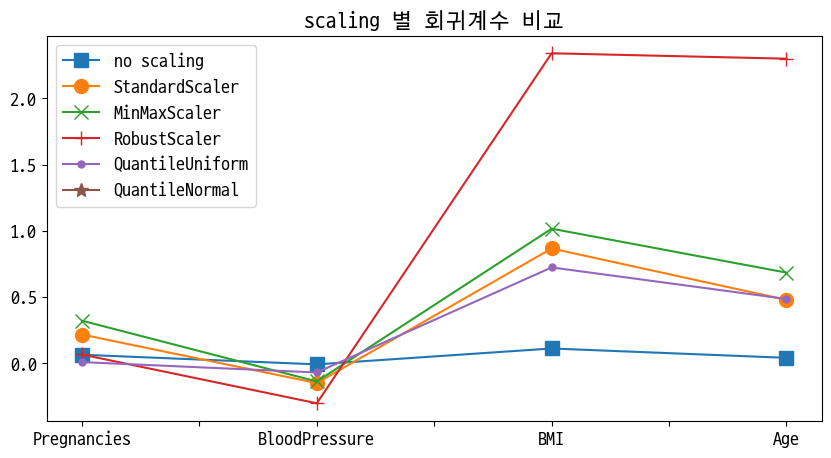

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title('scaling 별 회귀계수 비교')
for i, marker in enumerate(['s', 'o', 'x', '+', '.', '*']) : 
    coeffs.T.iloc[:,i].plot(ax=ax, marker=marker, ms=10)
ax.legend()
plt.show()

- 로그 변환

In [102]:
realestate = pd.read_csv('./data/2-4_realestate.csv')
X = realestate.filter(['X2 house age', 'X3 distance to the nearest MRT station',
                       'X4 number of convenience stores']).rename(columns={'X2 house age':'X2',
                                                                           'X3 distance to the nearest MRT station':'X3',
                                                                           'X4 number of convenience stores':'X4'})
y = realestate[['Y house price of unit area']]

In [103]:
# 상용로그
y_log = np.log10(y)

# 자연로그
y_log2 = np.log(y)

# 자연로그+1
y_log3 = np.log1p(y)
# np.log1m()을 통해 원래대로 되돌릴 수 있음.

# 데이터의 절대값에 자연로그 변환을 한 후, 데이터의 원래 부호 붙임(마이너스도 사용 가능)
y_log4 = np.sign(y)*np.log(np.abs(y))